In [1]:
import datetime
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.rcParams["font.family"] = "Times New Roman"
from numpy import vectorize
from src.source_codes import *
from scipy.interpolate import interp1d
from datetime import timedelta
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline

1. Plotting the summary of results for $\Pi$ and $\Delta T$

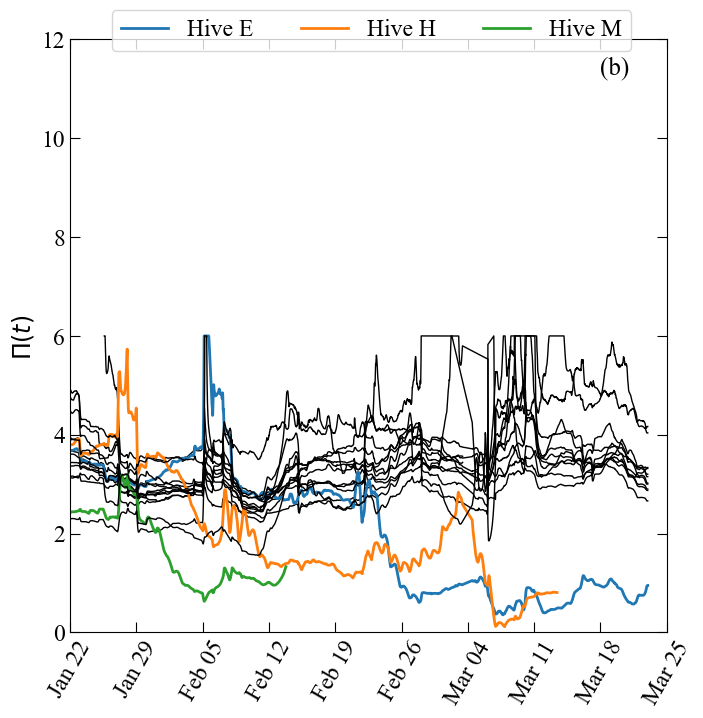

In [2]:
HIVES_INPUT=["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P"]
#HIVES_INPUT=["O"]

Stable=[]
Unstable=[]

color_=["#1f77b4","#ff7f0e","#2ca02c"]
i=0
fig = plt.figure(figsize=(7.7,7.7))
gs = fig.add_gridspec(1,1)
ax0 = fig.add_subplot(gs[0, 0])


with open("output/Hives_2020_M2.pickle", "rb") as f: 
    Set_2 = pickle.load(f)

for l in HIVES_INPUT:  
    Pi_   =np.array(Set_2[f"{l}"]["Pi"]) 
    Delta_=np.array(Set_2[f"{l}"]["delta"]) 
    Time_=np.array(Set_2[f"{l}"]["Time"]) 

    if l in ["E","H","M"]:
        index_start=np.where((np.array(Pi_) - 1)**2 < 0.01)[0]
        Critical_day=Time_[index_start[0]]
        gap_days= np.array([(t - Critical_day).days for t in Time_])
        Result=np.vstack((Pi_,Delta_,gap_days)).T
        Unstable.append(Result)
        
        ax0.plot(Time_,Pi_,'-',color=color_[i],alpha=1,linewidth = '2',label=f"Hive {l}")
        i=i+1

    else:
        gap_days= np.repeat(0,len(Pi_))
        Result=np.vstack((Pi_,Delta_,gap_days)).T
        
        ax0.plot(Time_,Pi_,'-',color="black",alpha=1,linewidth = '1')
        Stable.append(Result)

date_format = mdates.DateFormatter('%b %d')  # Format as "Month Day" (e.g., "Nov 01")
ax0.xaxis.set_major_formatter(date_format)
# Set xticks to be every 7th day from the minimum to the maximum date:
start_date = datetime(2020, 1, 22, 0, 0)
end_date = datetime(2020, 3, 25, 0, 0)
xticks_dates = [start_date + timedelta(days=7*i) for i in range((end_date - start_date).days // 7 + 1)]
ax0.set_xticks(xticks_dates)




ax0.set_ylabel(r'$\Pi(t)$ ', fontsize=17)
ax0.tick_params(axis='both',direction="in", which='both', top=True, bottom=True, left=True, right=True, labelsize=17, length=7)
ax0.tick_params(axis='x', rotation=60)
ax0.set_ylim([0,12])
ax0.set_xlim([start_date,end_date])
ax0.text(datetime(2020, 3, 17, 22, 0), 11.3, '(b)', fontsize=18)
plt.legend(loc='upper left', bbox_to_anchor=(0.05, 1.07),ncol=4, fontsize=17)
plt.savefig('output/Pi_correlation.pdf', format='pdf', dpi=700, bbox_inches='tight')
        
    

2. Plotting color map for $\Pi$ and $\Delta T$

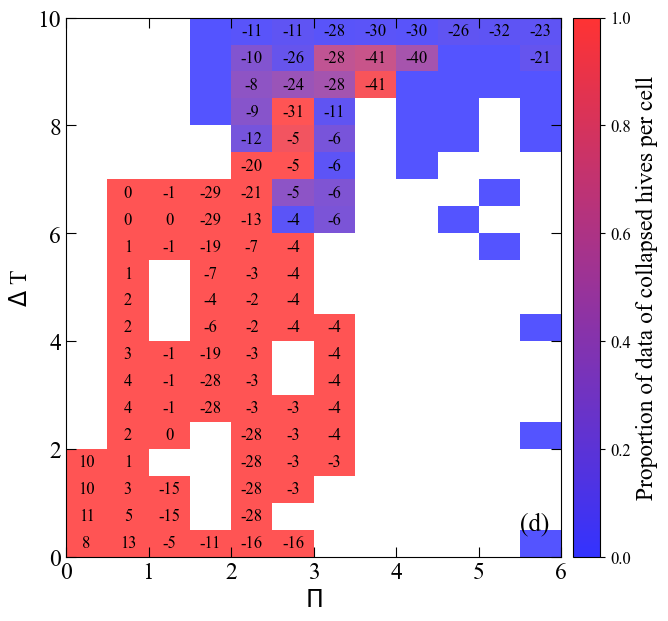

In [3]:
fig = plt.figure(figsize=(7.7,7.0))
gs = fig.add_gridspec(1,1)
ax1 = fig.add_subplot(gs[0, 0])

UNSTABLE=np.vstack(Unstable); 
STABLE=np.vstack(Stable);


# Plot size
x_range = [0, 6]
y_range = [0, 10]

# Grid resolution
resolution = 0.5
# Create a grid of squares
x = np.arange(x_range[0], x_range[1] + resolution, resolution)
y = np.arange(y_range[0], y_range[1] + resolution, resolution)
X, Y = np.meshgrid(x, y)

# Create a grid of colors:
array_stable=np.zeros((len(y)-1,len(x)-1))
array_unstable=np.zeros((len(y)-1,len(x)-1))

# Create a custom colormap that maps values from -1 to 1 to a color range from red to blue !!!
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['blue','purple', 'red'])

# Calculate data for each square:
for i in range(len(y) - 1): #rows
    for j in range(len(x) - 1): #columns
        x_min, x_max = X[i][j], X[i][j + 1]
        y_min, y_max = Y[i][j], Y[i + 1][j]

        # Count unhealthy points in the square
        red_count = np.sum((UNSTABLE[:, 0] >= x_min) & (UNSTABLE[:, 0] <= x_max) &
                           (UNSTABLE[:, 1] >= y_min) & (UNSTABLE[:, 1] <= y_max))

        # Count healthy points in the square
        blue_count = np.sum((STABLE[:, 0] >= x_min) & (STABLE[:, 0] <= x_max) &
                            (STABLE[:, 1] >= y_min) & (STABLE[:, 1] <= y_max))
        
        #############################For the counting down (days)##########################################
        if red_count > 0:
            mask_red = ((UNSTABLE[:, 0] >= x_min) & (UNSTABLE[:, 0] <= x_max) & 
                        (UNSTABLE[:, 1] >= y_min) & (UNSTABLE[:, 1] <= y_max))
            red_indices=np.where(mask_red)[0]
            average= np.mean(UNSTABLE[:,2][red_indices])
            ax1.text((x_min + x_max) / 2, (y_min + y_max) / 2, f"{int(average)}", 
                     ha='center', va='center', fontsize=12, color='black')
            #print(average)
        ###################################################################################################
        
        
        # Calculate percentage of unhealthy points:
        if red_count + blue_count > 0:
            percentage = red_count / (red_count + blue_count)
        else:
            percentage = np.nan
            
        # Plot colored square only if percentage is not NaN:
        if np.isnan(percentage):
            color = 'white'  # Plot NaN values as white
        else:
            color = cmap(percentage)

        #array_days_c = percentage

        # Plot colored square
        #color = cmap(percentage)
        ax1.add_patch(plt.Rectangle((x_min, y_min), resolution, resolution, fc=color, alpha=.67))
        array_unstable[i][j]=red_count ; array_stable[i][j]=blue_count

# Set plot limits and labels:
ax1.set_xlim([0, 6])
ax1.set_ylim([0, 10])
ax1.text(5.5, 0.5, '(d)', fontsize=18)
ax1.set_xlabel(r'$\Pi$', fontsize=17)
ax1.set_ylabel(r'$\Delta$ T', fontsize=17)
ax1.tick_params(axis='both',direction="in", which='both', top=True, bottom=True, left=True, right=True, labelsize=17, length=7)

# Add color bar:
norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, orientation='vertical', pad=0.02,alpha=.8)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Proportion of data of collapsed hives per cell', fontsize=17)



plt.savefig('output/Fig_DeltaT_Pi_2020_colormap_m2.pdf', format='pdf', dpi=700, bbox_inches='tight')
plt.show()


3. After evaluating the 4 grid plots from Set-1 and Set-2, we establish the region limits as follows: 

1
2
3
4
5
E= 3.8958333333333335 375
6
7
8
H= 7.197916666666667 692
9
10
11
12
13
M= 4.75 383
14
15
16


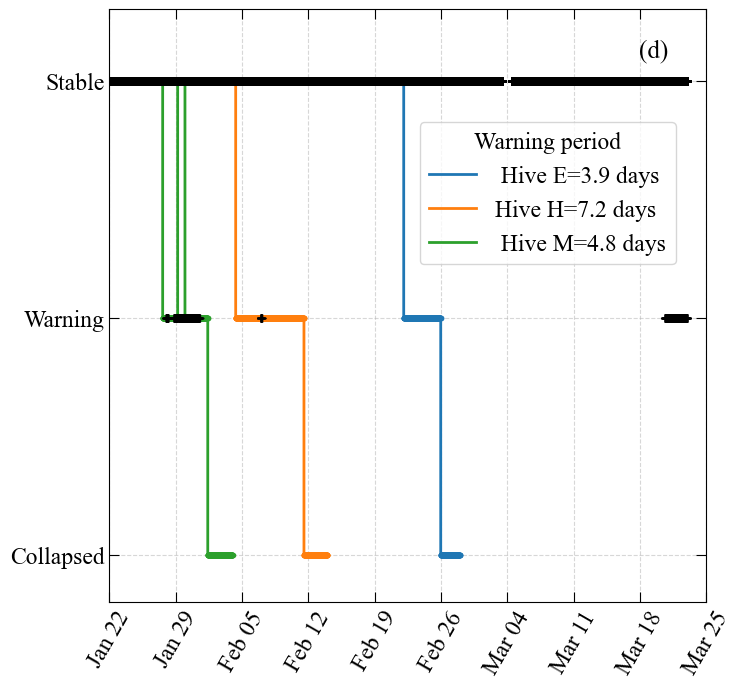

In [4]:
fig = plt.figure(figsize=(7.7,7.7))
gs = fig.add_gridspec(1,1)
ax1 = fig.add_subplot(gs[0, 0])

i=0
STATUS={}
labels_for_legend = []  # List to store special legend labels for E, H, M
handles_for_legend= []
Summary_percentages=np.zeros((2,2))

for l in HIVES_INPUT:
    i=i+1;print(i)
    status=[]
    Pi_   =np.array(Set_2[f"{l}"]["Pi"]) 
    Delta_=np.array(Set_2[f"{l}"]["delta"]) 
    Time_=np.array(Set_2[f"{l}"]["Time"]) 
    Time_1=[] ; Time_2=[]
        
    for j in range(len(Pi_)):
        if (0.5< Pi_[j]  <=1.0 and Delta_[j] <=6.5) or (Pi_[j]  <= 1.5 and Delta_[j] <= 4):
            label=0
        elif (1.5< Pi_[j] <=3.5 and 0<= Delta_[j] <=4) or (1.0< Pi_[j] <=3.5 and 4<= Delta_[j] <=8)or (0.5< Pi_[j] < 1.0 and Delta_[j] >6.5):
            label=0.5
        elif (Pi_[j]<=0.5 and Delta_[j]>=4.0) :
            label=nan
        else:
            label=1
        status.append(label)
        
    STATUS[f"{l}"]=status

    # Stop the record in case of consecutive collapsing status
    chop_idx = find_chop_index(Time_, status)
    Time_=Time_[:chop_idx]
    status=status[:chop_idx]
    # Regarding the frequency at which a stable hive was identified as being at risk of collapse or an unstable hive was identified as being at risk of collapse.
    if l=="E":
        result=np.array(status).T
        index=np.where(result==0.5)
        time_warning=Time_[index]
        delta_time= time_warning[-1]-time_warning[0]
        time_days= delta_time.total_seconds() / 86400
        print("E=",time_days,len(index[0]))
        Summary_percentages[0,1]=Summary_percentages[0,1]+len(index[0])
        Summary_percentages[1,1]=Summary_percentages[1,1]+len(np.where(result==1)[0])
        col="#1f77b4"
        marker_=".";linestyle_="-"
        labels_for_legend.append(f" Hive {l}={time_days:.2} days")
        custom_handle = Line2D([0], [0], color=col, linestyle=linestyle_, linewidth=2.0)
        handles_for_legend.append(custom_handle)
    elif l=="H":
        result=np.array(status).T
        index=np.where(result==0.5)
        time_warning=Time_[index]
        delta_time= time_warning[-1]-time_warning[0]
        time_days=delta_time.total_seconds() / 86400
        print("H=",time_days,len(index[0]))
        Summary_percentages[0,1]=Summary_percentages[0,1]+len(index[0])
        Summary_percentages[1,1]=Summary_percentages[1,1]+len(np.where(result==1)[0])
        col="#ff7f0e";linestyle_="-"
        marker_="."
        labels_for_legend.append(f"Hive H={time_days:.2} days")
        custom_handle = Line2D([0], [0], color=col, linestyle=linestyle_, linewidth=2.0)
        handles_for_legend.append(custom_handle)
    elif l=="M":
        result=np.array(status).T
        index=np.where(result==0.5)
        time_warning=Time_[index]
        delta_time= time_warning[-1]-time_warning[0]
        time_days= delta_time.total_seconds() / 86400
        print("M=",time_days,len(index[0]))
        Summary_percentages[0,1]=Summary_percentages[0,1]+len(index[0])
        Summary_percentages[1,1]=Summary_percentages[1,1]+len(np.where(result==1)[0])
        col="#2ca02c"
        marker_=".";linestyle_="-"
        labels_for_legend.append(f" Hive {l}={time_days:.2} days")
        custom_handle = Line2D([0], [0], color=col, linestyle=linestyle_, linewidth=2.0)
        handles_for_legend.append(custom_handle)
    else:
        result=np.array(status).T
        index=np.where(result==0.5)
        time_warning=Time_[index]
        Summary_percentages[0,0]=Summary_percentages[0,0]+len(index[0])
        Summary_percentages[1,0]=Summary_percentages[1,0]+len(np.where(result==1)[0])
        if len(time_warning) > 0:
             delta_time= time_warning[-1]-time_warning[0]
             time_days= delta_time.total_seconds() / 86400
             #print("Other period =", time_days/len(time_warning),time_days)
             
        #labels_for_legend.append("Hive")
        col="black"
        marker_="+";linestyle_=" "
        
    
    ax1.step(Time_,status, where='post',marker=marker_,linestyle=linestyle_, linewidth=2.0, color=col,label=f" Hive {l}={time_days:.3} days " if l in ["E", "H", "M"] else "")

ax1.tick_params(axis='both',direction="in", which='both', top=True, bottom=True, left=True, right=True, labelsize=17, length=7)
ax1.set_yticks([0, 0.5, 1], ['Collapsed', 'Warning', 'Stable'])  # Label the y-ticks
plt.grid(True, linestyle='--', alpha=0.5)  # Add gridlines for better readability
plt.grid(True, which='both', axis='x', linestyle='--', alpha=0.5) 

# Set xticks to be every 7th day from the minimum to the maximum date:
start_date = datetime(2020, 1, 22, 0, 0)
end_date = datetime(2020, 3, 25, 0, 0)
xticks_dates = [start_date + timedelta(days=7*i) for i in range((end_date - start_date).days // 7 + 1)]

date_format = mdates.DateFormatter('%b %d')  # Format as "Month Day" (e.g., "Nov 01")
ax1.xaxis.set_major_formatter(date_format)

ax1.set_xticks(xticks_dates)
ax1.tick_params(axis='x', rotation=60)
ax1.set_ylim([-0.1,1.15])
ax1.set_xlim([start_date,end_date])
ax1.text(datetime(2020, 3, 17, 22, 0), 1.05, '(d)', fontsize=18)

ax1.legend(handles_for_legend, labels_for_legend,
           loc="best", bbox_to_anchor=(.50, .55),
           title="Warning period", fontsize=17, title_fontsize=17)
#plt.savefig('output/warning_period_method_2.pdf', format='pdf', dpi=700, bbox_inches='tight')

Text(0.75, 2, '0%')

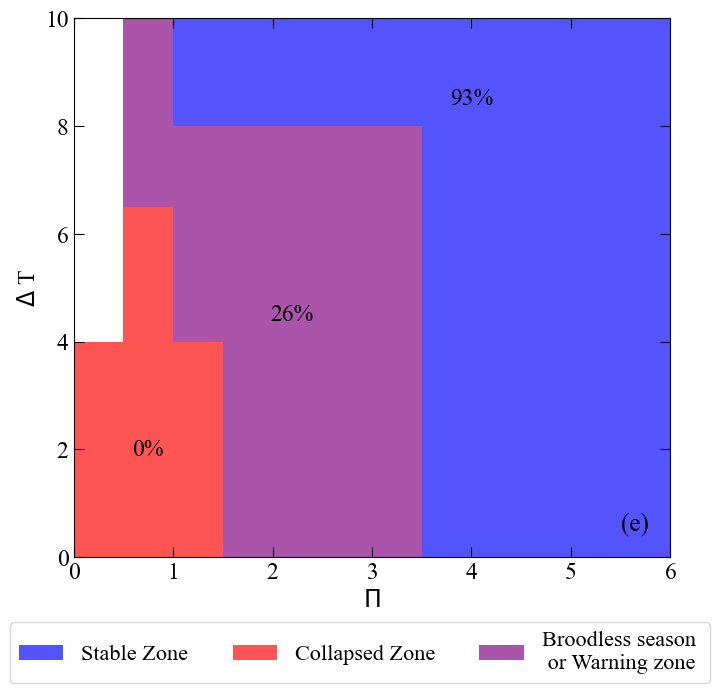

In [5]:
fig = plt.figure(figsize=(7.7,7.0))
gs = fig.add_gridspec(1,1)
ax1 = fig.add_subplot(gs[0, 0])
collapse_stable=[]; collapse_unstable=[];

for i in range(len(y)-1):
    for j in range(len(x)-1):
        # Initialize counters

        x_min, x_max = X[i][j], X[i][j+1]
        y_min, y_max = Y[i][j], Y[i+1][j]
        

        if  (0.5< x_max <=1.0 and y_max <=6.5) or (x_max <= 1.5 and y_max <= 4):
            collapse_unstable.append(array_unstable[i][j]); collapse_stable.append(array_stable[i][j])
            ax1.add_patch(plt.Rectangle((x_min, y_min), resolution, resolution, fc='red', alpha=0.67))
        elif (1.5< x_max <=3.5 and 0<= y_max <=4) or (1.0< x_max <=3.5 and 4<= y_max <=8)or (0.5< x_max <=1.0 and y_max >6.5):
           ax1.add_patch(plt.Rectangle((x_min, y_min), resolution, resolution, fc='purple', alpha=0.67))
        elif (x_max<=0.5 and y_max>=4.0):
            ax1.add_patch(plt.Rectangle((x_min, y_min), resolution, resolution, fc='white', alpha=0.67))
        else:
            ax1.add_patch(plt.Rectangle((x_min, y_min), resolution, resolution, fc='blue', alpha=0.67))

ax1.text(2.2, 4.5, f"{Summary_percentages[0,0]/sum(Summary_percentages[0,:]):.0%}", ha='center', va='center', fontsize=17, color='black')
ax1.text(4, 8.5, f"{Summary_percentages[1,0]/sum(Summary_percentages[1,:]):.0%}", ha='center', va='center', fontsize=17, color='black')
            
ax1.set_xlim([0,6])
ax1.set_ylim([0,10])

ax1.text(5.5, 0.5, '(e)', fontsize=18)
ax1.set_xlabel(r'$\Pi$', fontsize=17)
ax1.set_ylabel(r'$\Delta$ T', fontsize=17)
ax1.tick_params(axis='both',direction="in", which='both', top=True, bottom=True, left=True, right=True, labelsize=17, length=7)
# Define legend handles and labels
legend_handles = [
    Patch(facecolor='blue', alpha=0.67),
    Patch(facecolor='red', alpha=0.67),
    Patch(facecolor='purple', alpha=0.67),
    
]

legend_labels = [
    'Stable Zone',
    'Collapsed Zone',
    'Broodless season \n or Warning zone',
    
]

ax1.legend(handles=legend_handles , labels=legend_labels , loc='upper center', fontsize=16, bbox_to_anchor=(0.48, -0.1), ncol=3)
ax1.text(0.75, 2, f"{sum(collapse_stable)/(sum(collapse_stable)+sum(collapse_unstable)):.0%}", ha='center', va='center', fontsize=17, color='black')
#plt.savefig('output/Fig_DeltaT_Pi_Summary.pdf', format='pdf', dpi=700, bbox_inches='tight')
